## SNN model

In [43]:
import math
import pandas
import numpy as np
import functools
import matplotlib.pyplot as plt
import random

### 1. Реализовать модель импульсной нейронной сети (SRM)

In [44]:
class SRM:
    def __init__(self, neurons, threshold, t_current, t_membrane, eta_reset, simulation_window_size=100):

        threshold = np.array(threshold)
        t_current = np.array(t_current)
        t_membrane = np.array(t_membrane)
        eta_reset = np.array(eta_reset)

        self.neurons = neurons
        self.threshold = threshold
        self.t_current = t_current
        self.t_membrane = t_membrane
        self.eta_reset = eta_reset
        self.simulation_window_size = simulation_window_size
        self.cache = {}
        self.cache['last_t'] = -1
        self.cache['last_spike'] = np.ones(
            self.neurons, dtype=float) * -1000000
        self.cache['last_potential'] = np.zeros(self.neurons, dtype=float)

    def eta(self, s):
        eta_s = - self.eta_reset*np.exp(-s/self.t_membrane)
        return eta_s

    @functools.lru_cache()
    def eps(self, s):
        eps_s = (1/(1-self.t_current/self.t_membrane)) * \
            (np.exp(-s/self.t_membrane) - np.exp(-s/self.t_current))
        return eps_s

    @functools.lru_cache()
    def eps_matrix(self, k, size):
        matrix = np.zeros((self.neurons, size), dtype=float)
        for i in range(k):
            matrix[:, i] = self.eps(k-i)
        return matrix

    # Функция для изменения spiketrain во время t
    def spikes(self, spiketrain, weights, t):
        spiketrain_window = spiketrain[:, max(
            0, t+1-self.simulation_window_size):t+1]
        if self.cache['last_t'] == -1 or self.cache['last_t'] == t - 1:
            last_spike = self.cache['last_spike']
            last_potential = self.cache['last_potential']
        else:
            last_spike = t - np.argmax(spiketrain_window[:, ::-1], axis=1)
            last_potential = np.zeros(self.neurons)

        neurons, timesteps = spiketrain_window.shape

        epsilon_matrix = self.eps_matrix(
            min(self.simulation_window_size, t), timesteps)

        incoming_spikes = np.dot(weights.T, spiketrain_window)
        incoming_potential = np.sum(incoming_spikes * epsilon_matrix, axis=1)
        total_potential = self.eta(
            np.ones(neurons)*t - last_spike) + incoming_potential

        # Новый спайк, если мембранный потенциал всех нейронов достиг treshold
        neurons_high_current = np.where(
            (total_potential > self.threshold) & (last_potential < self.threshold))
        spiketrain[neurons_high_current, t] = True

        # Обновляем cache
        spiking_neurons = np.where(spiketrain[:, t])
        self.cache['last_spike'][spiking_neurons] = t
        self.cache['last_potential'] = total_potential
        self.cache['last_t'] = t

        return total_potential

### Анализ
### 1. Проверка реализации сети

In [45]:
# Функция для генерации случайных весов между нейронами

def weight(inp, out):
    total_neuron = inp + out
    a = np.random.uniform(0, 1, (inp, out))
    b = np.zeros((out, out))
    w = np.concatenate((a, b), axis=0) 
    weight = np.zeros((total_neuron, inp))
    weight = np.concatenate((weight, w), axis=1) 
    weight = (weight + weight.T)
    
    return weight

In [84]:
# Функция для реализации

def NNet(w_in, w_hid, w_out, sec):

    # From Input to first Hidden Layer
    neurons = input_Neuron + hidden1_Neuron
    srm_model = SRM(neurons=neurons, threshold=1, t_current=0.3,
                    t_membrane=20, eta_reset=5)
    models = [srm_model]

    sp = np.random.uniform(0, 1, (neurons, sec))
    spiketrain = np.stack([np.round(x) for x in sp], axis=0)

    for model in models:
        neurons, timesteps = spiketrain.shape
        for t in range(timesteps):
            total_current_1 = model.spikes(spiketrain, w_in, t)

    # From first Hidden to second Hidden Layer
    s = spiketrain[input_Neuron:, :].copy()
    hidden_spike = np.zeros((hidden2_Neuron, sec))
    spiketrain_2 = np.concatenate((s, hidden_spike))

    srm_model = SRM(neurons=hidden1_Neuron+hidden2_Neuron, threshold=1, t_current=0.3,
                    t_membrane=20, eta_reset=5)
    models = [srm_model]

    for model in models:
        neurons, timesteps = spiketrain_2.shape
        for t in range(timesteps):
            total_current_2 = model.spikes(spiketrain_2, w_hid, t)

    # From second Hidden to Output Layer
    s = spiketrain_2[hidden1_Neuron:, :].copy()
    hidden_spike = np.zeros((output_Neuron, sec))
    spiketrain_3 = np.concatenate((s, hidden_spike))

    srm_model = SRM(neurons=hidden2_Neuron+output_Neuron, threshold=1, t_current=0.3,
                    t_membrane=20, eta_reset=5)
    models = [srm_model]

    for model in models:
        neurons, timesteps = spiketrain_3.shape
        for t in range(timesteps):
            total_current_3 = model.spikes(spiketrain_3, w_out, t)
    inp_layer = spiketrain[:input_Neuron, :].copy()
    hid_layer1 = spiketrain[input_Neuron:, :].copy()
    hid_layer2 = spiketrain_2[hidden1_Neuron:, :].copy()
    out_layer = spiketrain_3[hidden2_Neuron:, :].copy()

    return [inp_layer.T, hid_layer1.T, hid_layer2.T, out_layer.T]

In [85]:
# Сгенерируем три случайных паттерна возбуждения и построим нейросети

input_Neuron = 5
hidden1_Neuron = 10
hidden2_Neuron = 20
output_Neuron = 2
sec = 30

w_in = weight(input_Neuron, hidden1_Neuron)
w_hid = weight(hidden1_Neuron, hidden2_Neuron)
w_out = weight(hidden2_Neuron, output_Neuron)

network1 = NNet(w_in, w_hid, w_out, sec)
network2 = NNet(w_in, w_hid, w_out, sec)
network3 = NNet(w_in, w_hid, w_out, sec)

In [86]:
# Суммируем число активных нейронов в каждую секунду в каждом слое

def summ_n(network, layer):
    act = []
    for i in range(len(network[layer])):
        act.append(sum(network[layer][i]))
    return act

In [87]:
act_in1 = summ_n(network1, 0)
act_in2 = summ_n(network2, 0)
act_in3 = summ_n(network3, 0)
act_in = np.array([act_in1, act_in2, act_in3]).T

act_hid1 = summ_n(network1, 1)
act_hid2 = summ_n(network2, 1)
act_hid3 = summ_n(network3, 1)
act_hid_1 = np.array([act_hid1, act_hid2, act_hid3]).T

act_hid1 = summ_n(network1, 2)
act_hid2 = summ_n(network2, 2)
act_hid3 = summ_n(network3, 2)
act_hid_2 = np.array([act_hid1, act_hid2, act_hid3]).T

act_out1 = summ_n(network1, 3)
act_out2 = summ_n(network2, 3)
act_out3 = summ_n(network3, 3)
act_out = np.array([act_out1, act_out2, act_out3]).T

In [88]:
# Найдем среднее число активных нейронов для каждого слоя

def mean_n(act_smth):
    act = []
    for i in range(len(act_smth)):
        act.append(np.mean(act_smth[i]))
    return act

In [89]:
act_in = mean_n(act_in)
act_hid_1 = mean_n(act_hid_1)
act_hid_2 = mean_n(act_hid_2)
act_out = mean_n(act_out)

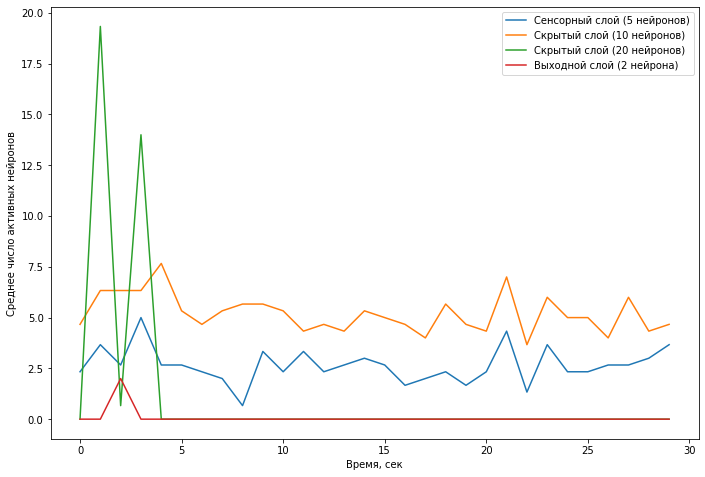

In [90]:
# Рисуем графики

%matplotlib inline

time = range(sec)

axes = plt.figure().add_axes([0, 0, 1.5, 1.5])

axes.plot(time, act_in, label='Сенсорный слой (5 нейронов)')
axes.plot(time, act_hid_1, label='Скрытый слой (10 нейронов)')
axes.plot(time, act_hid_2, label='Скрытый слой (20 нейронов)')
axes.plot(time, act_out, label='Выходной слой (2 нейрона)')

axes.set_ylabel('Среднее число активных нейронов')
axes.set_xlabel('Время, сек')

axes.legend()

# plt.savefig('mean_n' + '.jpg')

In [91]:
# Теперь найдем самый активный нейрон

def summ_n2(network, layer):
    act = []
    matrix = network[layer].T
    for i in range(len(matrix)):
        act.append(sum(matrix[i]))
    return act

act_in1 = summ_n2(network1, 0)
act_in2 = summ_n2(network2, 0)
act_in3 = summ_n2(network3, 0)
act_in = np.array([act_in1, act_in2, act_in3]).T

act_hid1 = summ_n2(network1, 1)
act_hid2 = summ_n2(network2, 1)
act_hid3 = summ_n2(network3, 1)
act_hid_1 = np.array([act_hid1, act_hid2, act_hid3]).T

act_hid1 = summ_n2(network1, 2)
act_hid2 = summ_n2(network2, 2)
act_hid3 = summ_n2(network3, 2)
act_hid_2 = np.array([act_hid1, act_hid2, act_hid3]).T

act_out1 = summ_n2(network1, 3)
act_out2 = summ_n2(network2, 3)
act_out3 = summ_n2(network3, 3)
act_out = np.array([act_out1, act_out2, act_out3]).T

In [92]:
act_in = mean_n(act_in)
act_hid_1 = mean_n(act_hid_1)
act_hid_2 = mean_n(act_hid_2)
act_out = mean_n(act_out)

max(max(act_in), max(act_hid_1), max(act_hid_2), max(act_out))

19.666666666666668

In [93]:
act_in

[14.666666666666666,
 19.666666666666668,
 16.666666666666668,
 15.0,
 13.666666666666666]

**Следовательно, в среднем самый активный нейрон это 4й нейрон сенсорного слоя. Нарисуем график спайков нейрона.**

In [94]:
neuron_1 = network1[0].T
neuron_1 = neuron_1[3]

neuron_2 = network2[0].T
neuron_2 = neuron_2[3]

neuron_3 = network3[0].T
neuron_3 = neuron_3[3]

Text(0.5, 0, 'Время, сек')

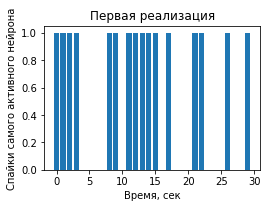

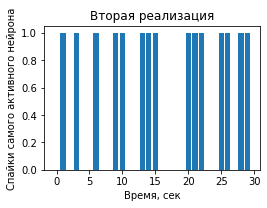

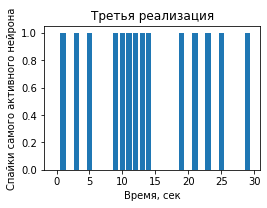

In [95]:
time = range(sec)

axes = plt.figure().add_axes([0, 0, 0.5, 0.5])
axes.bar(time, neuron_1)
axes.set_title('Первая реализация') 
axes.set_ylabel('Спайки самого активного нейрона')
axes.set_xlabel('Время, сек')


axes = plt.figure().add_axes([0, 0, 0.5, 0.5])
axes.bar(time, neuron_2)
axes.set_title('Вторая реализация') 
axes.set_ylabel('Спайки самого активного нейрона')
axes.set_xlabel('Время, сек')


axes = plt.figure().add_axes([0, 0, 0.5, 0.5])
axes.bar(time, neuron_3)
axes.set_title('Третья реализация') 
axes.set_ylabel('Спайки самого активного нейрона')
axes.set_xlabel('Время, сек')

### 2. STDP (Unsupervised Learning) обучение без учителя на датасете MNIST
Теперь зададим веса не случайно, а обучившись на данных с помощью STDP  
The MNIST dataset: http://yann.lecun.com/exdb/mnist/  
28 x 28 pixel images of a single digit (0 to 9)

In [96]:
class STDP:
    
    def __init__(self, eta, w_in, w_out, tau, window_size):
        
        self.eta = eta
        self.w_in = w_in
        self.w_out = w_out
        self.tau = tau
        self.window_size = window_size

    def learning_window_neuron_pre(self, t1, t2_list):
        sum_result = 0
        for t2 in t2_list:
            sum_result += self.learning_window(t2 - t1)
        return sum_result

    def learning_window_neuron_post(self, t1, t2_list):
        sum_result = 0
        for t2 in t2_list:
            sum_result += self.learning_window(t1 - t2)
        return sum_result

    def learning_window(self, x):
        if x > 0:
            return - np.exp(-x / self.tau)
        elif x < 0:
            return np.exp(x / self.tau)
        else:
            return 0

    def weight_change(self, spikes, weights, t):
        
        spikes = spikes[:, max(0, t+1-self.window_size):t+1]

        if not spikes.any():
            return np.zeros(weights.shape)

        neurons, current_time = spikes.shape
        current_time -= 1

        connected_neurons = np.array(weights, dtype=bool)

        last_spikes = spikes[:, -1]
        last_spikes = last_spikes[:, np.newaxis]

        weight_change_presynaptic = last_spikes * connected_neurons * self.w_in

        weight_change_postsynaptic = last_spikes.T * connected_neurons * self.w_out

        spikes_time = []
        for neuron in range(neurons):
            spikes_time.append([])
            for time, spike in enumerate(spikes[neuron, :]):
                if spike:
                    spikes_time[neuron].append(time)

        neuron_learnwindow_pre = [self.learning_window_neuron_pre(current_time, x) for x in spikes_time]
        neuron_learnwindow_pre = np.array(neuron_learnwindow_pre, ndmin=2).T

        neuron_learnwindow_post = [self.learning_window_neuron_post(current_time, x) for x in spikes_time]
        neuron_learnwindow_post = np.array(neuron_learnwindow_post, ndmin=2).T

        learning_window_presynaptic = (last_spikes.T * connected_neurons) * neuron_learnwindow_pre
        learning_window_postsynaptic = (last_spikes * connected_neurons) * neuron_learnwindow_post.T

        # Меняем веса
        weight_change = self.eta * (weight_change_presynaptic + weight_change_postsynaptic + learning_window_presynaptic
                               + learning_window_postsynaptic)

        weights = weights.__iadd__(weight_change)

        return weight_change

In [97]:
# Найдем spiketrains
import imageio

img = imageio.imread("/Users/elizaveta/Desktop/1.png") # Цифра 1

spiketrains = []
for p in img.flatten():
    bins = int(10)
    spiketrain = []
    for j in range(256+128):
        spike = []
        for i in range(bins):
            if p <= 126:
                spike.append(0)  # spike
            elif p < 255:
                spike.append(random.randint(0,1))
            elif p == 255:
                spike.append(1)
        spiketrain.append(spike)
    spiketrains.append(spiketrain)

In [98]:
input_Neuron = 256
hidden1_Neuron = 128
hidden2_Neuron = 64
output_Neuron = 10
sec = 30

w_inp = weight(input_Neuron, hidden1_Neuron)

In [99]:
learning = STDP(eta=0.05, w_in=0.5, w_out=0.5, tau=10.0, window_size=4)
changes = []
for i in range(784):
    changes.append(learning.weight_change(np.array(spiketrains[i]), w_inp, 2))

In [100]:
w_inp # Новые веса, которые можно использовать для SRM

array([[0.        , 0.        , 0.        , ..., 2.28377361, 2.00234783,
        2.43257655],
       [0.        , 0.        , 0.        , ..., 1.79745308, 2.49228769,
        2.69777493],
       [0.        , 0.        , 0.        , ..., 1.31808609, 2.47445604,
        1.85891654],
       ...,
       [2.52939284, 2.28869153, 2.90374011, ..., 0.        , 0.        ,
        0.        ],
       [1.71367527, 2.27687754, 3.31901879, ..., 0.        , 0.        ,
        0.        ],
       [2.29042881, 2.54701653, 2.35015499, ..., 0.        , 0.        ,
        0.        ]])

In [101]:
w_hid = weight(hidden1_Neuron, hidden2_Neuron)
w_out = weight(hidden2_Neuron, output_Neuron)

network = NNet(w_inp, w_hid, w_out, sec)

### 3. Reinforcement Learning

In [102]:
class reward(SRM):
    def __init__(self, num_input, hidden_layers, num_output, neuron_class, learning_method, reward_controller):
        super(self.__class__, self).__init__(num_input, hidden_layers,
                                             num_output, neuron_class, learning_method)
        self.reward_controller = reward_controller

    def solve(self, input, individual):
        previous_layer = np.array(input)
        for (i, layer) in enumerate(self.layers):
            new_previous_layer = np.array([])
            for neuron in layer:
                neuron.reward = self.reward_controller(individual)
                new_previous_layer = np.append(
                    new_previous_layer, neuron.solve(previous_layer))
            previous_layer = new_previous_layer
        self.adjust_weights()
        return previous_layer